In [47]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt         #for visualization
import seaborn as sns    #for visualization
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# Data preprocessing

In [3]:
data = pd.read_csv('dataset.txt', sep=",", header=None)
data.columns = ["date","S1","S2"]

In [4]:
data

,date,S1,S2
0,2016-07-03,122.19,123.46
1,2016-07-03,122.19,123.48
2,2016-07-03,122.31,123.55
3,2016-07-03,122.41,123.57
4,2016-07-03,122.42,123.65
...,...,...,...
27560,2016-10-21,120.14,121.94
27561,2016-10-21,120.23,122.03
27562,2016-10-21,120.20,122.04
27563,2016-10-21,120.22,122.15


In [5]:
data.describe()

,S1,S2
count,27565.000000,27565.000000
mean,125.046003,125.885200
std,5.309172,5.088079
min,116.460000,117.200000
25%,121.420000,122.170000
50%,123.830000,124.830000
75%,129.030000,129.570000
max,138.690000,138.800000


# Stationity test

In [6]:
#Perform Augmented Dickey–Fuller test:
# the null hypothesis that a unit root 
print('Results of Dickey Fuller Test:')
S1_result = adfuller(data.S1)
S2_result = adfuller(data.S2)

print("For S1:")
print('ADF Statistic: {}'.format(S1_result[0])) 
print('p-value: {}'.format(S1_result[1])) 

print("For S2:")
print('ADF Statistic: {}'.format(S2_result[0])) 
print('p-value: {}'.format(S2_result[1])) 

Results of Dickey Fuller Test:
For S1:
ADF Statistic: -1.065950928802209
p-value: 0.7284575872160847
For S2:
ADF Statistic: -1.0890618033651203
p-value: 0.7194141614849747


the p-value is greater than the threshold (0.05). Thus, we can conclude that the time series of price is not stationary.

In [7]:
# ADF test on return
data["S1_return"] = data.S1.pct_change()
data["S2_return"] = data.S2.pct_change()
print('Results of Dickey Fuller Test:')
S1_result = adfuller(data.S1_return.dropna())
S2_result = adfuller(data.S2_return.dropna())

print("For S1:")
print('ADF Statistic: {}'.format(S1_result[0])) 
print('p-value: {}'.format(S1_result[1])) 

print("For S2:")
print('ADF Statistic: {}'.format(S2_result[0])) 
print('p-value: {}'.format(S2_result[1])) 

Results of Dickey Fuller Test:
For S1:
ADF Statistic: -38.8068219336877
p-value: 0.0
For S2:
ADF Statistic: -33.897820445757745
p-value: 0.0


p-values are small than 0.05,Therefore, we have suffcient evidence to say the time series on return is stationary.

# lead-lag effect

# Corr matrix 

In [176]:
df_lag = data.loc[1:,["S1_return","S2_return"]]
for i in range(10):
    df_lag[f"S1_lag_{i}"] = df_lag.S1_return.shift(i)
for i in range(10):    
    df_lag[f"S2_lag_{i}"] = df_lag.S2_return.shift(i)

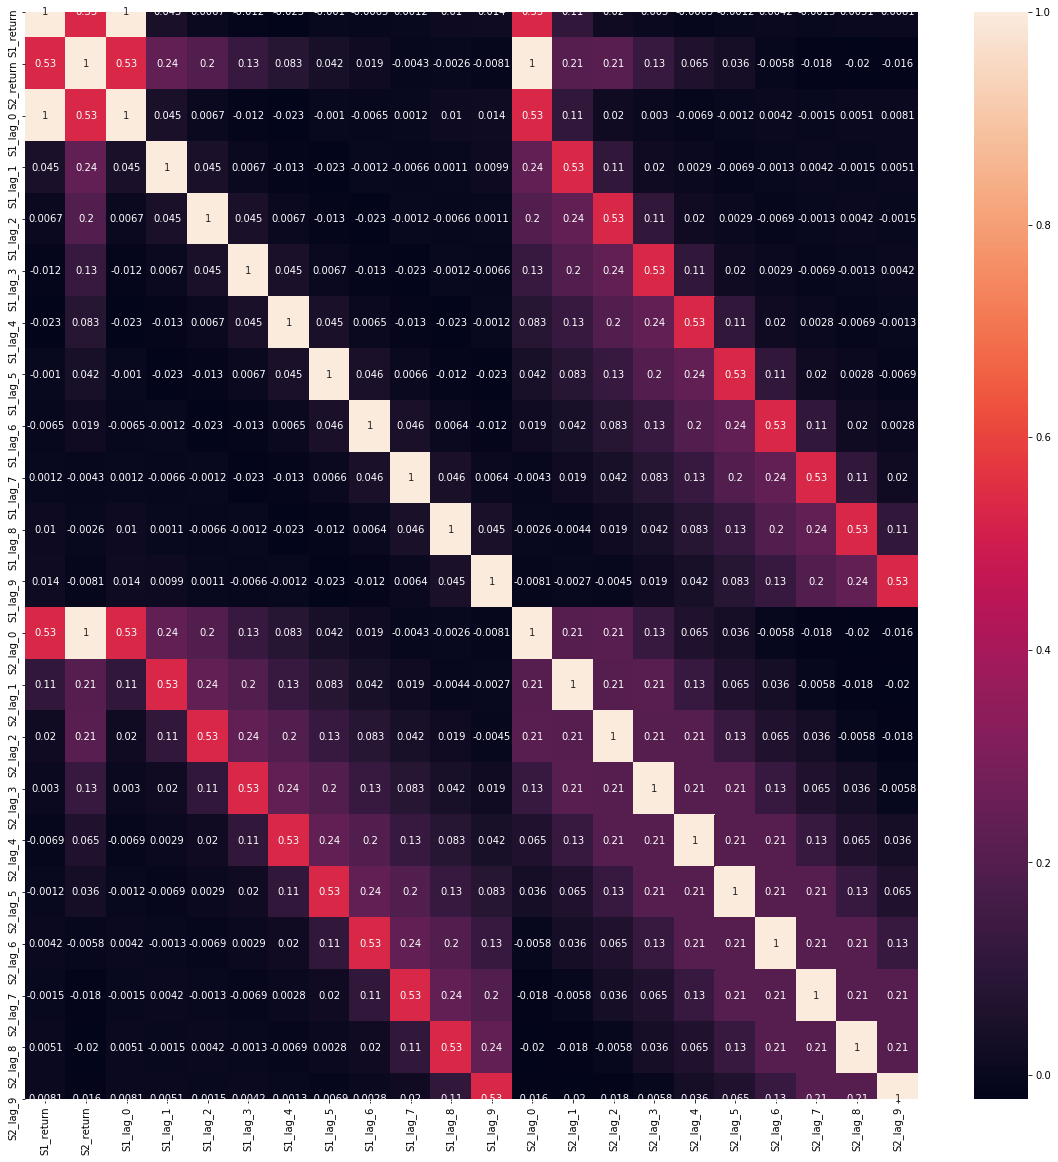

In [177]:
plt.figure(figsize = (20,20))
sns.heatmap(df_lag.corr(),annot=True)

The table above can sightly show the lead-leg effect that S2 is the lagged series.

There is not much corrlation on S1 return for both lagged S1 and S2 return.

There is larger corrlation on S2 return for both lagged S1 and S2 return.

# Cointegration  ( Engel-Granger method (Residual Based Approach))

In [24]:
#Cointegration  (we use the Engel-Granger method (Residual Based Approach))
from statsmodels.tsa.stattools import coint
print(coint(df_lag.S1_return,df_lag.S2_return))

(-59.04238250803732, 0.0, array([-3.89683738, -3.33635169, -3.04460388]))


P-value < 0.5 and t-statistic << -3.89683738 (1% Critical values)
So there is a cointergration between them

# granger causality tests
#asssumption: stationity
#wiki: The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another

In [28]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(df_lag[["S1_return","S2_return"]], maxlag=100)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=300.6545, p=0.0000  , df_denom=27560, df_num=1
ssr based chi2 test:   chi2=300.6872, p=0.0000  , df=1
likelihood ratio test: chi2=299.0589, p=0.0000  , df=1
parameter F test:         F=300.6545, p=0.0000  , df_denom=27560, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=158.0956, p=0.0000  , df_denom=27557, df_num=2
ssr based chi2 test:   chi2=316.2487, p=0.0000  , df=2
likelihood ratio test: chi2=314.4481, p=0.0000  , df=2
parameter F test:         F=158.0956, p=0.0000  , df_denom=27557, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=119.9083, p=0.0000  , df_denom=27554, df_num=3
ssr based chi2 test:   chi2=359.8162, p=0.0000  , df=3
likelihood ratio test: chi2=357.4877, p=0.0000  , df=3
parameter F test:         F=119.9083, p=0.0000  , df_denom=27554, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=101.4150

ssr based F test:         F=16.4108 , p=0.0000  , df_denom=27479, df_num=28
ssr based chi2 test:   chi2=460.4558, p=0.0000  , df=28
likelihood ratio test: chi2=456.6483, p=0.0000  , df=28
parameter F test:         F=16.4108 , p=0.0000  , df_denom=27479, df_num=28

Granger Causality
number of lags (no zero) 29
ssr based F test:         F=15.8624 , p=0.0000  , df_denom=27476, df_num=29
ssr based chi2 test:   chi2=460.9969, p=0.0000  , df=29
likelihood ratio test: chi2=457.1804, p=0.0000  , df=29
parameter F test:         F=15.8624 , p=0.0000  , df_denom=27476, df_num=29

Granger Causality
number of lags (no zero) 30
ssr based F test:         F=15.3056 , p=0.0000  , df_denom=27473, df_num=30
ssr based chi2 test:   chi2=460.1885, p=0.0000  , df=30
likelihood ratio test: chi2=456.3851, p=0.0000  , df=30
parameter F test:         F=15.3056 , p=0.0000  , df_denom=27473, df_num=30

Granger Causality
number of lags (no zero) 31
ssr based F test:         F=14.8098 , p=0.0000  , df_denom=27470, d

ssr based F test:         F=8.7202  , p=0.0000  , df_denom=27398, df_num=55
ssr based chi2 test:   chi2=481.5533, p=0.0000  , df=55
likelihood ratio test: chi2=477.3870, p=0.0000  , df=55
parameter F test:         F=8.7202  , p=0.0000  , df_denom=27398, df_num=55

Granger Causality
number of lags (no zero) 56
ssr based F test:         F=8.5776  , p=0.0000  , df_denom=27395, df_num=56
ssr based chi2 test:   chi2=482.3261, p=0.0000  , df=56
likelihood ratio test: chi2=478.1463, p=0.0000  , df=56
parameter F test:         F=8.5776  , p=0.0000  , df_denom=27395, df_num=56

Granger Causality
number of lags (no zero) 57
ssr based F test:         F=8.4067  , p=0.0000  , df_denom=27392, df_num=57
ssr based chi2 test:   chi2=481.1952, p=0.0000  , df=57
likelihood ratio test: chi2=477.0348, p=0.0000  , df=57
parameter F test:         F=8.4067  , p=0.0000  , df_denom=27392, df_num=57

Granger Causality
number of lags (no zero) 58
ssr based F test:         F=8.2585  , p=0.0000  , df_denom=27389, d

ssr based F test:         F=6.0725  , p=0.0000  , df_denom=27317, df_num=82
ssr based chi2 test:   chi2=500.9491, p=0.0000  , df=82
likelihood ratio test: chi2=496.4381, p=0.0000  , df=82
parameter F test:         F=6.0725  , p=0.0000  , df_denom=27317, df_num=82

Granger Causality
number of lags (no zero) 83
ssr based F test:         F=5.9949  , p=0.0000  , df_denom=27314, df_num=83
ssr based chi2 test:   chi2=500.6152, p=0.0000  , df=83
likelihood ratio test: chi2=496.1100, p=0.0000  , df=83
parameter F test:         F=5.9949  , p=0.0000  , df_denom=27314, df_num=83

Granger Causality
number of lags (no zero) 84
ssr based F test:         F=5.9643  , p=0.0000  , df_denom=27311, df_num=84
ssr based chi2 test:   chi2=504.1010, p=0.0000  , df=84
likelihood ratio test: chi2=499.5331, p=0.0000  , df=84
parameter F test:         F=5.9643  , p=0.0000  , df_denom=27311, df_num=84

Granger Causality
number of lags (no zero) 85
ssr based F test:         F=5.8758  , p=0.0000  , df_denom=27308, d

{1: ({'ssr_ftest': (300.65447252886406, 5.383623206774749e-67, 27560.0, 1),
   'ssr_chi2test': (300.6871997936531, 2.3337495268566525e-67, 1),
   'lrtest': (299.05891952471575, 5.2820458314640535e-67, 1),
   'params_ftest': (300.6544725288667, 5.3836232067667924e-67, 27560.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (158.09564516601097, 5.380862315620674e-69, 27557.0, 2),
   'ssr_chi2test': (316.24866074431867, 2.1255722163924582e-69, 2),
   'lrtest': (314.44808931916486, 5.229557973483863e-69, 2),
   'params_ftest': (158.0956451660093, 5.380862315629086e-69, 27557.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (119.9082669189009, 3.720270179589917e-77, 27554.0, 3),
   'ssr_chi2test': (359.8161876190565, 1.117094766506408e-77, 3),
   'lrtest': (357.48768385109724, 3.567107321456651e-77, 3),
   'params_ftest': (119.90826691890071, 3.720270179589917e-77, 27554.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0

In [29]:
grangercausalitytests(df_lag[["S2_return","S1_return"]], maxlag=100)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=645.6935, p=0.0000  , df_denom=27560, df_num=1
ssr based chi2 test:   chi2=645.7638, p=0.0000  , df=1
likelihood ratio test: chi2=638.3153, p=0.0000  , df=1
parameter F test:         F=645.6935, p=0.0000  , df_denom=27560, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=465.0634, p=0.0000  , df_denom=27557, df_num=2
ssr based chi2 test:   chi2=930.2956, p=0.0000  , df=2
likelihood ratio test: chi2=914.9401, p=0.0000  , df=2
parameter F test:         F=465.0634, p=0.0000  , df_denom=27557, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=375.1458, p=0.0000  , df_denom=27554, df_num=3
ssr based chi2 test:   chi2=1125.7234, p=0.0000  , df=3
likelihood ratio test: chi2=1103.3409, p=0.0000  , df=3
parameter F test:         F=375.1458, p=0.0000  , df_denom=27554, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=303.69

ssr based F test:         F=45.9935 , p=0.0000  , df_denom=27479, df_num=28
ssr based chi2 test:   chi2=1290.4903, p=0.0000  , df=28
likelihood ratio test: chi2=1261.1633, p=0.0000  , df=28
parameter F test:         F=45.9935 , p=0.0000  , df_denom=27479, df_num=28

Granger Causality
number of lags (no zero) 29
ssr based F test:         F=44.4495 , p=0.0000  , df_denom=27476, df_num=29
ssr based chi2 test:   chi2=1291.8043, p=0.0000  , df=29
likelihood ratio test: chi2=1262.4174, p=0.0000  , df=29
parameter F test:         F=44.4495 , p=0.0000  , df_denom=27476, df_num=29

Granger Causality
number of lags (no zero) 30
ssr based F test:         F=42.9519 , p=0.0000  , df_denom=27473, df_num=30
ssr based chi2 test:   chi2=1291.4188, p=0.0000  , df=30
likelihood ratio test: chi2=1262.0482, p=0.0000  , df=30
parameter F test:         F=42.9519 , p=0.0000  , df_denom=27473, df_num=30

Granger Causality
number of lags (no zero) 31
ssr based F test:         F=41.5939 , p=0.0000  , df_denom=27

ssr based F test:         F=23.6120 , p=0.0000  , df_denom=27398, df_num=55
ssr based chi2 test:   chi2=1303.9199, p=0.0000  , df=55
likelihood ratio test: chi2=1273.9602, p=0.0000  , df=55
parameter F test:         F=23.6120 , p=0.0000  , df_denom=27398, df_num=55

Granger Causality
number of lags (no zero) 56
ssr based F test:         F=23.2064 , p=0.0000  , df_denom=27395, df_num=56
ssr based chi2 test:   chi2=1304.9195, p=0.0000  , df=56
likelihood ratio test: chi2=1274.9135, p=0.0000  , df=56
parameter F test:         F=23.2064 , p=0.0000  , df_denom=27395, df_num=56

Granger Causality
number of lags (no zero) 57
ssr based F test:         F=22.8212 , p=0.0000  , df_denom=27392, df_num=57
ssr based chi2 test:   chi2=1306.2688, p=0.0000  , df=57
likelihood ratio test: chi2=1276.2007, p=0.0000  , df=57
parameter F test:         F=22.8212 , p=0.0000  , df_denom=27392, df_num=57

Granger Causality
number of lags (no zero) 58
ssr based F test:         F=22.5086 , p=0.0000  , df_denom=27

ssr based F test:         F=16.1826 , p=0.0000  , df_denom=27317, df_num=82
ssr based chi2 test:   chi2=1334.9914, p=0.0000  , df=82
likelihood ratio test: chi2=1303.5797, p=0.0000  , df=82
parameter F test:         F=16.1826 , p=0.0000  , df_denom=27317, df_num=82

Granger Causality
number of lags (no zero) 83
ssr based F test:         F=15.9854 , p=0.0000  , df_denom=27314, df_num=83
ssr based chi2 test:   chi2=1334.8971, p=0.0000  , df=83
likelihood ratio test: chi2=1303.4887, p=0.0000  , df=83
parameter F test:         F=15.9854 , p=0.0000  , df_denom=27314, df_num=83

Granger Causality
number of lags (no zero) 84
ssr based F test:         F=15.7902 , p=0.0000  , df_denom=27311, df_num=84
ssr based chi2 test:   chi2=1334.5834, p=0.0000  , df=84
likelihood ratio test: chi2=1303.1885, p=0.0000  , df=84
parameter F test:         F=15.7902 , p=0.0000  , df_denom=27311, df_num=84

Granger Causality
number of lags (no zero) 85
ssr based F test:         F=15.6163 , p=0.0000  , df_denom=27

{1: ({'ssr_ftest': (645.6935482353784, 8.09039767956147e-141, 27560.0, 1),
   'ssr_chi2test': (645.7638341803968, 1.8637959301397997e-142, 1),
   'lrtest': (638.3152629162068, 7.768667171053534e-141, 1),
   'params_ftest': (645.6935482353781, 8.090397679574348e-141, 27560.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (465.0633939884583, 2.2873358464872913e-199, 27557.0, 2),
   'ssr_chi2test': (930.2955521362911, 9.747372969176467e-203, 2),
   'lrtest': (914.9400700365077, 2.105174765253123e-199, 2),
   'params_ftest': (465.06339398846586,
    2.2873358464655782e-199,
    27557.0,
    2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (375.145825841051, 7.811447946667452e-239, 27554.0, 3),
   'ssr_chi2test': (1125.7233910871605, 9.556805251688338e-244, 3),
   'lrtest': (1103.3408633173676, 6.8590457305828176e-239, 3),
   'params_ftest': (375.14582584105136, 7.811447946655018e-239, 27554.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.

From the results above, we see a lager number in F-statis, so we assume the S1 is the leading series, and S2 is the lagged series.

From all the results above we can conclude the S1 is the leading series, and S2 is the lagged series.

# Build Features

In [45]:
data.groupby("date").count()

,S1,S2,S1_return,S2_return
date,,,,
2016-07-03,383,383,382,382
2016-07-04,382,382,382,382
2016-07-07,382,382,382,382
2016-07-08,382,382,382,382
2016-07-09,382,382,382,382
...,...,...,...,...
2016-10-15,382,382,382,382
2016-10-16,382,382,382,382
2016-10-17,382,382,382,382


In [337]:
features = data.loc[1:,["S1"]]
for i in range(1,5):
    features[f'lag_{i}'] = features.S1.shift(i)
for i in range(2,50):
    features[f'rolling_mean_{i}'] = features.S1.rolling(i).mean()
for i in range(2,50):
    features[f'rolling_vol_{i}'] = features.S1.rolling(i).std()
y = data.loc[1:,["S2"]]
features = features.tail(len(features)-50)
features.drop(columns=["S1"],inplace = True)
y = y.tail(len(y)-50)

In [338]:
features

,lag_1,lag_2,lag_3,lag_4,rolling_mean_2,rolling_mean_3,rolling_mean_4,rolling_mean_5,rolling_mean_6,rolling_mean_7,...,rolling_vol_40,rolling_vol_41,rolling_vol_42,rolling_vol_43,rolling_vol_44,rolling_vol_45,rolling_vol_46,rolling_vol_47,rolling_vol_48,rolling_vol_49
51,122.24,122.22,122.25,122.22,122.285,122.263333,122.2600,122.252,122.251667,122.251429,...,0.104058,0.106851,0.109668,0.112507,0.114597,0.117136,0.120100,0.125644,0.127762,0.129318
52,122.33,122.24,122.22,122.25,122.305,122.283333,122.2675,122.264,122.256667,122.255714,...,0.101286,0.103877,0.106515,0.109194,0.111909,0.113910,0.116359,0.119234,0.124650,0.126719
53,122.28,122.33,122.24,122.22,122.300,122.310000,122.2925,122.278,122.273333,122.265714,...,0.100524,0.102366,0.104707,0.107117,0.109589,0.112116,0.113973,0.116276,0.119006,0.124225
54,122.32,122.28,122.33,122.24,122.385,122.350000,122.3450,122.324,122.306667,122.298571,...,0.107379,0.107860,0.109143,0.110908,0.112778,0.114745,0.116800,0.118275,0.120188,0.122525
55,122.45,122.32,122.28,122.33,122.435,122.396667,122.3675,122.360,122.340000,122.322857,...,0.112760,0.112290,0.112472,0.113397,0.114786,0.116299,0.117928,0.119663,0.120880,0.122525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27560,120.25,120.06,120.04,119.89,120.195,120.150000,120.1225,120.076,120.035000,120.002857,...,0.170985,0.185545,0.197711,0.207520,0.210991,0.214690,0.218954,0.218247,0.217020,0.216430
27561,120.14,120.25,120.06,120.04,120.185,120.206667,120.1700,120.144,120.101667,120.062857,...,0.179578,0.181541,0.195401,0.207083,0.216567,0.219979,0.223612,0.227793,0.227125,0.225933
27562,120.23,120.14,120.25,120.06,120.215,120.190000,120.2050,120.176,120.153333,120.115714,...,0.186924,0.187024,0.188987,0.202413,0.213801,0.223098,0.226508,0.230133,0.234294,0.233686
27563,120.20,120.23,120.14,120.25,120.210,120.216667,120.1975,120.208,120.183333,120.162857,...,0.194181,0.194204,0.194354,0.196323,0.209357,0.220474,0.229598,0.233010,0.236630,0.240772


In [339]:
data.groupby("date").count()

,S1,S2,S1_return,S2_return
date,,,,
2016-07-03,383,383,382,382
2016-07-04,382,382,382,382
2016-07-07,382,382,382,382
2016-07-08,382,382,382,382
2016-07-09,382,382,382,382
...,...,...,...,...
2016-10-15,382,382,382,382
2016-10-16,382,382,382,382
2016-10-17,382,382,382,382


In [340]:
def train_test_split(x, y, test_size):
    inx = int(len(x) * (1 - test_size))
    x_train = x[:inx]
    x_test = x[inx:]
    y_train = y[:inx]
    y_test = y[inx:]
    return x_train, x_test, y_train, y_test

In [341]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def MAPE(y,y_pre):
    y=np.array(y)
    y_pre=np.array(y_pre)
    n = len(y)
    return (sum(np.abs((y - y_pre)/y))/n*100)[0]
def rmspe(y_true, y_predict):
    y1 = np.array(y_predict)
    y2 = np.array(y_true)
    n = len(y_true)
    temp = np.square((y1 - y2)/y2).sum()
    score = np.sqrt(temp/n)
    return score

# LinearRegression (model 1)

In [342]:
X_train, X_test, y_train, y_test = train_test_split(features, y, 0.3)
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize = False)
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [343]:
LR.coef_

array([[-3.67547093e-01, -1.93534512e+11, -7.13032477e+10,
        -7.82719392e+10, -3.87069024e+11,  3.66693793e+11,
        -2.78747659e+10,  3.91359696e+11,  3.96881270e-02,
         1.04221344e-01,  4.37927246e-03,  7.90672302e-02,
        -4.27970886e-02, -9.35096741e-02,  6.09855652e-02,
        -2.26478577e-02, -6.40707016e-02,  4.76818085e-02,
         1.61880493e-01, -2.40207672e-01,  7.08160400e-02,
         4.43725586e-02,  1.11389160e-03,  8.46862793e-03,
        -2.18597412e-01,  1.99096680e-01,  4.49218750e-02,
        -1.35650635e-02,  1.60217285e-02,  5.54962158e-02,
        -9.73968506e-02, -1.21963501e-01,  2.04391479e-01,
        -1.43829346e-01, -9.97772217e-02,  2.84667969e-01,
        -2.48954773e-01,  2.88551331e-01, -2.59357452e-01,
        -5.27496338e-02,  2.12448597e-01, -1.85317993e-01,
         2.26516724e-02,  6.83135986e-02, -2.31765747e-01,
         6.99119568e-01, -7.16079712e-01,  4.05288696e-01,
        -7.01904297e-01,  7.12890625e-01, -1.76751709e+0

From the coef we see that the individual lagged price of leading series does not contribute much on the prediction except the lagged 1 price. 

In [344]:
print('MAE', mean_absolute_error(y_test,prediction))
print('MSE', mean_squared_error(y_test,prediction))
print('RMSE', np.sqrt(mean_squared_error(y_test,prediction)))
print('MAPE', MAPE(y_test,prediction))
print('RMSPE', rmspe(y_test,prediction))
print('R^2', r2_score(y_test,prediction))

MAE 0.4311195370226068
MSE 0.2868663947270026
RMSE 0.5355990988855401
MAPE 0.3290911107154004
RMSPE 0.00411217976581457
R^2 0.9849832700417648


MAE_mean 0.6660059991353183
MAE_std 0.526402551566426


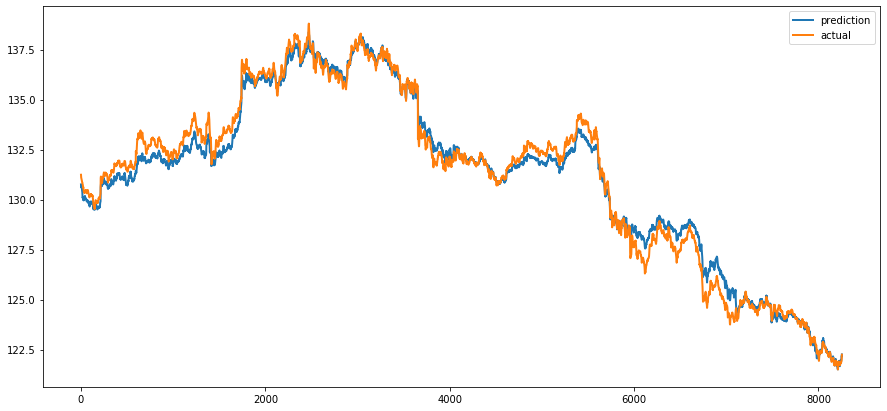

In [345]:
plt.figure(figsize=(15, 7))
num = prediction.size
# num = 20
x = range(num)
plt.plot(x, prediction[:num], label='prediction', linewidth=2.0)
plt.plot(x, y_test[:num], label='actual', linewidth=2.0)
plt.legend()
cv = cross_val_score(model, X_train, y_train, 
                     cv = TimeSeriesSplit(n_splits=20), scoring='neg_mean_absolute_error')
mae = -1 * cv.mean()
deviation = cv.std()
print("MAE_mean",mae)
print("MAE_std",deviation)

# RandomForest(model 2)

In [307]:
X_train, X_test, y_train, y_test = train_test_split(features, y, 0.3)
from sklearn.linear_model import LinearRegression
model = RandomForestRegressor(max_depth=10, n_estimators=100)
model.fit(X_train, y_train)
prediction = model.predict(X_test)

/Users/liuxichen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [308]:
print('MAE', mean_absolute_error(y_test,prediction))
print('MSE', mean_squared_error(y_test,prediction))
print('RMSE', np.sqrt(mean_squared_error(y_test,prediction)))
print('MAPE', MAPE(y_test,prediction))
print('RMSPE', rmspe(y_test,prediction))
print('R^2', r2_score(y_test,prediction))

MAE 2.1007131314482788
MSE 8.433327741488549
RMSE 2.904019239173279
MAPE 2.875029146543975
RMSPE 3.864832812654568
R^2 0.558536630044292


/Users/liuxichen/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/liuxichen/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/liuxichen/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/liuxichen/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection

MAE_mean 0.6232775063363272
MAE_std 0.25966123927546064


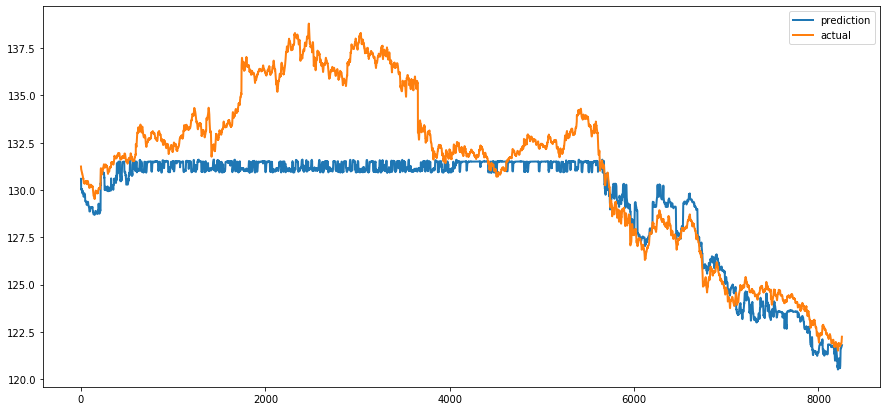

In [309]:
plt.figure(figsize=(15, 7))
num = prediction.size
# num = 20
x = range(num)
plt.plot(x, prediction[:num], label='prediction', linewidth=2.0)
plt.plot(x, y_test[:num], label='actual', linewidth=2.0)
plt.legend()
cv = cross_val_score(model, X_train, y_train, 
                     cv = TimeSeriesSplit(n_splits=20), scoring='neg_mean_absolute_error')
mae = -1 * cv.mean()
deviation = cv.std()
print("MAE_mean",mae)
print("MAE_std",deviation)

# Xgboost(model 3)

In [346]:
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(features, y, 0.3)
model =  xgb.XGBRegressor()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [347]:
print('MAE', mean_absolute_error(y_test,prediction))
print('MSE', mean_squared_error(y_test,prediction))
print('RMSE', np.sqrt(mean_squared_error(y_test,prediction)))
print('MAPE', MAPE(y_test,prediction))
print('RMSPE', rmspe(y_test,prediction))
print('R^2', r2_score(y_test,prediction))

MAE 2.0926137743001996
MSE 8.320438286667347
RMSE 2.8845169936520305
MAPE 2.968306823998126
RMSPE 3.8634931638204546
R^2 0.5644461073805818


MAE_mean 0.6322074266806033
MAE_std 0.2850492853580176


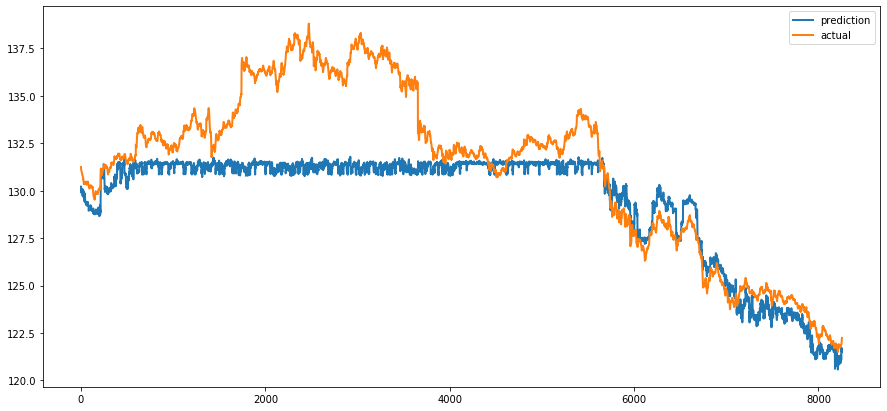

In [348]:
plt.figure(figsize=(15, 7))
num = prediction.size
# num = 20
x = range(num)
plt.plot(x, prediction[:num], label='prediction', linewidth=2.0)
plt.plot(x, y_test[:num], label='actual', linewidth=2.0)
plt.legend()
cv = cross_val_score(model, X_train, y_train, 
                     cv = TimeSeriesSplit(n_splits=20), scoring='neg_mean_absolute_error')
mae = -1 * cv.mean()
deviation = cv.std()
print("MAE_mean",mae)
print("MAE_std",deviation)

# Summary

### 1. Feature includes: 
1. laged 1-5 price data of leading series; 
2. moving average of windows_size from 2-50; 
3. moving std of windows_size from 2-50.

(I've tried only used the lagged price until 100, the result is not good as using the moving average)
### 2. Firstly divide the dataset into train and test with the test weight equals to 30%.
### 3. Test on three models: 
#### LinearRegression ; 
#### random foreast; 
#### XGboost
### 4. Use six evaluation criteria:
#### MSE (mean squared error)
#### MAE (mean absolute error):
#### RMSE (root mean squared error)
#### MAPE (mean absolute percentage error)
#### R2 (goodness of fit):
#### RMSPE (root mean square percent error)

### 5.  Validation

Use the TimeSeriesSplit function in sklearn package to do the cross validation since the time series data cannot use the afterwards data to predict the earlier data. Thus, we obtain the average cross validation score(mean_absolute_error)

### 6. Results
The LinearRegression does a best job as it gives the best R^2 and smallest MAPE and other errors.
From the chart we could see the LinearRegression plots a more clear and closer line to the real price.

### 7. Comments

1. Can further do feature selections in order to train better model and avoid over-fitting.
2. For linner regression model can also be improved as Polynomial regression.
3. Can use Garch to further model the vol evlution part.
4. liquidity(trading volume) can be another feature used in modeling.
5. Long_short_term_memory can be another model to use which probably have better perfomance than some model like ARIMA accoring to some papers and my class project.
6. Evlation method can be expand to the backtest result after deploying the trading signal we made since the predition model is use for trading ultimately.
   e.g.  Long when the predicted price have three consecutive up or 20% up in five time points. And then backtest the result, evalute the model by the sharpe ratio, Annualized returns, drawdrow, and also the return on turnover( when consider the transaction cost)